#  Simple tool to analyze data from https://data.europa.eu/

The EU Open Data Portal (EU ODP) aims to encourage the use of EU datasets for building third-party applications.

**Notes:** 
1. This is a Jupyter notebook which is also available as its executable export as a Python 3 script (therefore with automatically generated comments).
2. This version adapts to a significant change in format occurring early 2021: data was kept daily until 14 Dec 2020 and weekly thereafter. 
3. The update corresponding to the change in data format is expected around April 15th, 2021 ...*  since I became aware of this change rather late*.

# Libraries

In [1]:
# Sys import
import sys, os, re
# Common imports
import math
import numpy             as NP
import numpy.random      as RAND
import scipy.stats       as STATS
from scipy import sparse
from scipy import linalg

# Better formatting functions
from IPython.display import display, HTML
from IPython import get_ipython

import matplotlib        as MPL
import matplotlib.pyplot as PLT
import seaborn as SNS
SNS.set(font_scale=1)

# Python programming
from itertools import cycle
from time import time
import datetime

# Using pandas
import pandas as PAN
import xlrd
import numpy as NP

In [2]:
import warnings
warnings.filterwarnings('ignore')
print("For now, reduce python warnings, I will look into this later")

For now, reduce python warnings, I will look into this later


### Import my own modules
The next cell attempts to give user some information if things improperly setup.
Intended to work both in Jupyter and when executing the Python file directly.

In [3]:
if not get_ipython() is None and os.path.abspath("../source/") not in sys.path:
    sys.path.append(os.path.abspath("../source/"))
try:
    from lib.utilities     import *
    from lib.figureHelpers import *
    from lib.DataMgrRdf        import *
    import lib.basicDataCTE as DCTE
    from lib.pandaUtils    import *
    from libApp.appEU      import *

except Exception as err:
    print("Could not find library 'lib' with contents 'DataGouvFr' ")
    if get_ipython() is None:
        print("Check the PYTHONPATH environment variable which should point to 'source' wich contains 'lib'")
    else:
        print("You are supposed to be running in JupySessions, and '../source/lib' should exist")
    raise err

Loaded lib
For now, reduce python warnings, I will look into this later
Loaded libApp


## Check environment

It is expected that:
- your working directory is named `JupySessions`, 
- that it has subdirectories 
   - `images/*` where generated images may be stored to avoid overcrowding. 
- At the same level as your working dir there should be directories 
   - `../data` for storing input data and 
   - `../source` for python scripts.
   
My package library is in `../source/lib`, and users running under Python (not in Jupyter) should
set their PYTHONPATH to include "../source" ( *or whatever appropriate* ).

In [4]:
checkSetup(chap="Chap03")
ImgMgr = ImageMgr(chapdir="Chap03")

# Load Data

## Functions

## Load CSV and XLSX data from remote 
The `dataFileVMgr` will manage a cache of data files in `../dataEURdf`, the data will be downloaded
from  https://data.europa.eu using the SPARQL query endpoint. The meta information is stored/cached  in `../dataEURdf/.cache*`

We check what is in the cache/data directory; for each file, we identify the latest version, 
and list this below to make sure. The file name will usually contain a time stamp.

<FONT COLOR="RED">TO BE CHECKED For the files used in this notebook, the latest version is used/loaded irrespective of the
timestamp used in the notebook.</FONT>

In [5]:
dataFileVMgr = manageAndCacheDataFilesRdfEU( "../dataEURdf", maxDirSz= 180*(2**10)**2)
dataFileVMgr.getRemoteInfo()

Loaded pickle from ../dataEURdf/.cache.rdf, loaded 5h 36m 23s ago (367138 elts)
cache metadata:{   'HTTP:Hdr:resp': {'Date': 'Thu, 08 Apr 2021 09:37:36 GMT', 'Content-Type': 'application/rdf+xml; charset=UTF-8', 'Access-Control-Allow-Origin': '*', 'Server': 'Europa', 'Connection': 'close', 'Content-Encoding': 'gzip'},
    'HTTP:Hdr:rqt': {'User-Agent': 'python-requests/2.22.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': 'application/rdf+xml', 'Connection': 'keep-alive', 'Content-Type': 'application/rdf+xml', 'Content-Length': '0'},
    'HTTP:Query:Sparql': '\n'
                         'PREFIX http: <http://www.w3.org/2011/http#>\n'
                         'PREFIX dcat: <http://www.w3.org/ns/dcat#>\n'
                         'PREFIX odp:  <http://data.europa.eu/euodp/ontologies/ec-odp#>\n'
                         'PREFIX dc: <http://purl.org/dc/terms/>\n'
                         'PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\n'
                         'PREFIX foaf: <http://xm

Loading ../dataEURdf/.cache.prdf as xml... 

Parsed ../dataEURdf/.cache.prdf


done.	(18317 triples)


This can be long, the SPARQL processor used is not fast

In [6]:
dataFileVMgr.updatePrepare()
dataFileVMgr.cacheUpdate()

qn='ns1:DAILY'	mod=None
qn='ns1:DAILY'	mod=None
qn='ns1:DAILY'	mod=None
qn='ns1:WEEKLY'	mod=None
qn='ns1:WEEKLY'	mod=None
qn='ns1:WEEKLY'	mod=None
qn='ns1:WEEKLY'	mod=None
qn='ns1:DAILY'	mod=None


Unexpected file extension (json) or subdir casedistribution locationfor URL:
	https://opendata.ecdc.europa.eu/covid19/casedistribution/json
Unexpected file extension (xml) or subdir casedistribution locationfor URL:
	https://opendata.ecdc.europa.eu/covid19/casedistribution/xml
Unexpected file extension (csv) or subdir nationalcasedeath locationfor URL:
	https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/csv
Unexpected file extension (json) or subdir nationalcasedeath locationfor URL:
	https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/json
Unexpected file extension (xlsx) or subdir nationalcasedeath locationfor URL:
	https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/xlsx
Unexpected file extension (xml) or subdir nationalcasedeath locationfor URL:
	https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/xml
Unexpected file extension (xlsx) or subdir documents locationfor URL:
	https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribut

## Get some understanding of the available resource

In [7]:
nbLastDays = 30

## Dig into the data

In [8]:
print("Most recent versions of files in data directory:")
for f in dataFileVMgr.listMostRecent(nonTS=True) :
    print(f"\t{f}")

Most recent versions of files in data directory:
	.cache.prdf
	.cache.qhash
	.cache.rdf
	covid-19-coronavirus-data-daily-up-to-14-december-2020.csv
	covid-19-coronavirus-data-daily-up-to-14-december-2020.json
	covid-19-coronavirus-data-daily-up-to-14-december-2020.xlsx
	covid-19-coronavirus-data-daily-up-to-14-december-2020.xml
	covid-19-coronavirus-data-weekly-from-17-december-2020.csv
	covid-19-coronavirus-data-weekly-from-17-december-2020.json
	covid-19-coronavirus-data-weekly-from-17-december-2020.xlsx
	covid-19-coronavirus-data-weekly-from-17-december-2020.xml
	covid-19-coronavirus-data.csv
	covid-19-coronavirus-data.json
	news-and-press-releases-on-covid-19-pandemic-from-the-european-medicines-agency-ema.html


In [9]:
last = lambda x: dataFileVMgr.getRecentVersion(x,default=os.path.join(dataFileVMgr.dirpath,x))

In [10]:
dataFileVMgr.nonTSFiles

{'covid-19-coronavirus-data-weekly-from-17-december-2020.json': None,
 'covid-19-coronavirus-data-weekly-from-17-december-2020.xml': None,
 'news-and-press-releases-on-covid-19-pandemic-from-the-european-medicines-agency-ema.html': None,
 '.cache.rdf': None,
 'covid-19-coronavirus-data.csv': None,
 'covid-19-coronavirus-data-daily-up-to-14-december-2020.xml': None,
 '.cache.prdf': None,
 'covid-19-coronavirus-data-weekly-from-17-december-2020.csv': None,
 'covid-19-coronavirus-data-daily-up-to-14-december-2020.xlsx': None,
 '.cache.qhash': None,
 'covid-19-coronavirus-data-weekly-from-17-december-2020.xlsx': None,
 'covid-19-coronavirus-data.json': None,
 'covid-19-coronavirus-data-daily-up-to-14-december-2020.json': None,
 'covid-19-coronavirus-data-daily-up-to-14-december-2020.csv': None}

In [11]:
covidDataEUCsv = last("covid-19-coronavirus-data-weekly-from-17-december-2020.csv")
data_covidDataEU  = read_csvPandas(covidDataEUCsv , error_bad_lines=False,sep="," )

Explanations and description about this file is found at https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data-weekly-from-17-december-2020:

https://www.ecdc.europa.eu/en/publications-data/data-national-14-day-notification-rate-covid-19:
Data on 14-day notification rate of new COVID-19 cases and deaths
The downloadable data file contains information on the 14-day notification rate of newly reported COVID-19 cases per 100 000 population and the 14-day notification rate of reported deaths per million population by week and country. Each row contains the corresponding data for a certain day and per country. The file is updated weekly. You may use the data in line with ECDC’s copyright policy.
https://www.ecdc.europa.eu/sites/default/files/documents/2021-01-13_Variable_Dictionary_and_Disclaimer_national_weekly_data.pdf
rate_14_day 14-day notification rate of reported COVID-19 cases per 100
000 population OR 14-day notification rate of reported
deaths per 1 000 000 population



After the transformation to weekly data, check that numbers are really weekly, dates appear in 'DateRep' and also in 'year_week' in distinct formats. Checked weekly results with "StopCovid" application at https://www.gouvernement.fr/info-coronavirus/tousanticovid (still factor 2 discrepancy ?) .

In [12]:
msk= (data_covidDataEU.loc[:,'country'] == 'France') & (data_covidDataEU.loc[:,'indicator'] == 'cases')
data_covidDataEU[msk].iloc[-10:].describe()

,population,weekly_count,rate_14_day,cumulative_count
count,10.0,10.000000,10.000000,1.000000e+01
mean,67320216.0,163460.000000,465.528364,3.721818e+06
std,0.0,41835.496106,96.917049,4.829587e+05
min,67320216.0,128115.000000,398.170143,3.053617e+06
25%,67320216.0,140670.500000,406.458143,3.369077e+06
50%,67320216.0,145881.000000,428.496843,3.680574e+06
75%,67320216.0,163268.500000,462.763667,4.029805e+06
max,67320216.0,262986.000000,703.989126,4.545589e+06


In [13]:
data_covidDataEU[msk].iloc[-10:]

,country,country_code,continent,population,indicator,weekly_count,year_week,rate_14_day,cumulative_count,source
8641,France,FRA,Europe,67320216,cases,142628,2021-03,401.604475,3053617,"Epidemic intelligence, national weekly data"
8642,France,FRA,Europe,67320216,cases,143497,2021-04,425.020918,3197114,"Epidemic intelligence, national weekly data"
8643,France,FRA,Europe,67320216,cases,139934,2021-05,421.019148,3337048,"Epidemic intelligence, national weekly data"
8644,France,FRA,Europe,67320216,cases,128115,2021-06,398.170143,3465163,"Epidemic intelligence, national weekly data"
8645,France,FRA,Europe,67320216,cases,140018,2021-07,398.294919,3605181,"Epidemic intelligence, national weekly data"
8646,France,FRA,Europe,67320216,cases,150787,2021-08,431.972767,3755968,"Epidemic intelligence, national weekly data"
8647,France,FRA,Europe,67320216,cases,148265,2021-09,444.223174,3904233,"Epidemic intelligence, national weekly data"
8648,France,FRA,Europe,67320216,cases,167429,2021-10,468.943831,4071662,"Epidemic intelligence, national weekly data"
8649,France,FRA,Europe,67320216,cases,210941,2021-11,562.045137,4282603,"Epidemic intelligence, national weekly data"
8650,France,FRA,Europe,67320216,cases,262986,2021-12,703.989126,4545589,"Epidemic intelligence, national weekly data"


In [14]:
msk= (data_covidDataEU.loc[:,'country'] == 'France') & (data_covidDataEU.loc[:,'indicator'] == 'deaths')
data_covidDataEU[msk].iloc[:].describe()

,population,weekly_count,rate_14_day,cumulative_count
count,65.0,65.000000,64.000000,65.000000
mean,67320216.0,1455.738462,43.385927,36342.784615
std,0.0,1572.028410,45.759344,27711.356493
min,67320216.0,0.000000,0.000000,0.000000
25%,67320216.0,103.000000,2.885463,22856.000000
50%,67320216.0,656.000000,24.019531,30410.000000
75%,67320216.0,2560.000000,78.122893,55155.000000
max,67320216.0,6315.000000,175.088565,94623.000000


In [15]:
data_covidDataEU.columns

Index(['country', 'country_code', 'continent', 'population', 'indicator',
       'weekly_count', 'year_week', 'rate_14_day', 'cumulative_count',
       'source'],
      dtype='object')

This seems necessary, since there were NaNs in the "geoId" column

In [16]:
for coln in ( "country_code", "country"):
    si = sortedColIds(data_covidDataEU, coln)
    print(f"{coln:30}-> {len(si)} elts")

country_code                  -> 214 elts
country                       -> 220 elts


**New with version of data input** (2021, found this late in April):
Now we have to make do with "year_week" information in the form "yyyy-ww", as opposed to format="%d/%m/%Y".  Acceptable format documented at https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior.
Appropriate format is "%Y-%W-%w" where "%w" is day of week information.

You need also define start day:
~~~
a = pd.to_datetime('2017_01_0',format = '%Y_%W_%w')
print (a)
2017-01-08 00:00:00
~~~

### Lets visualize data from this *new* dataFrame

In [17]:
data_covidDataEU["date"] = PAN.to_datetime(data_covidDataEU.loc[:,"year_week"]+"-1", format="%Y-%W-%w")
dateStart = data_covidDataEU["date"].min()
dateEnd   = data_covidDataEU["date"].max() 
dateSpan  = dateEnd - dateStart 
print(f"Our statistics span {dateSpan.days+1} days, start: {dateStart} and end {dateEnd}")

data_covidDataEU["elapsedDays"] = (data_covidDataEU["date"] - dateStart).dt.days

Our statistics span 442 days, start: 2020-01-06 00:00:00 and end 2021-03-22 00:00:00


In [18]:
def prepareDataPerCountry(df, continent=None, minPop=None, maxPop=None):
 dt = df.copy()
 dt = dt.set_index("continent")
 sel = True
 if continent is not None:
    sel = dt.index == continent
 if minPop is not None:
    sel = sel & (dt.loc[:,"population"]>= minPop)
 if maxPop is not None:
    sel = sel & (dt.loc[:,"population"]>= maxPop)
    
 dtx = dt[sel]   
 dtg = dtx.groupby("country")
 return dtg

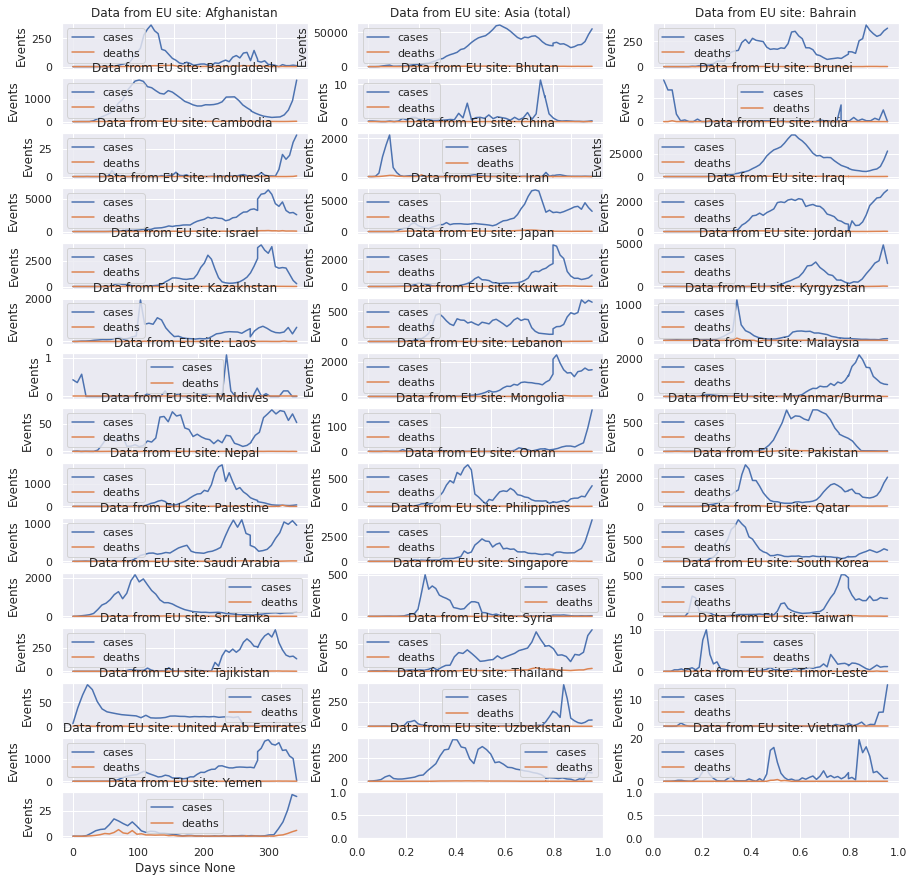

In [19]:
dtg = prepareDataPerCountry(data_covidDataEU, continent="Asia")
myEUConverter = EUSiteData()
argDict = { "breakCond" : lambda count, country : count > 45,
            "countryDataAdapter" :myEUConverter }

myFig =  perCountryFigure(**argDict )

plotCols = ( "cases", "deaths")

myFig.initPainter( subnodeSpec=45, maxCol=3)
myFig.mkImage( dtg, plotCols)
 

This is too detailed, let's specialize for the larger countries.

Saving figure FIG001


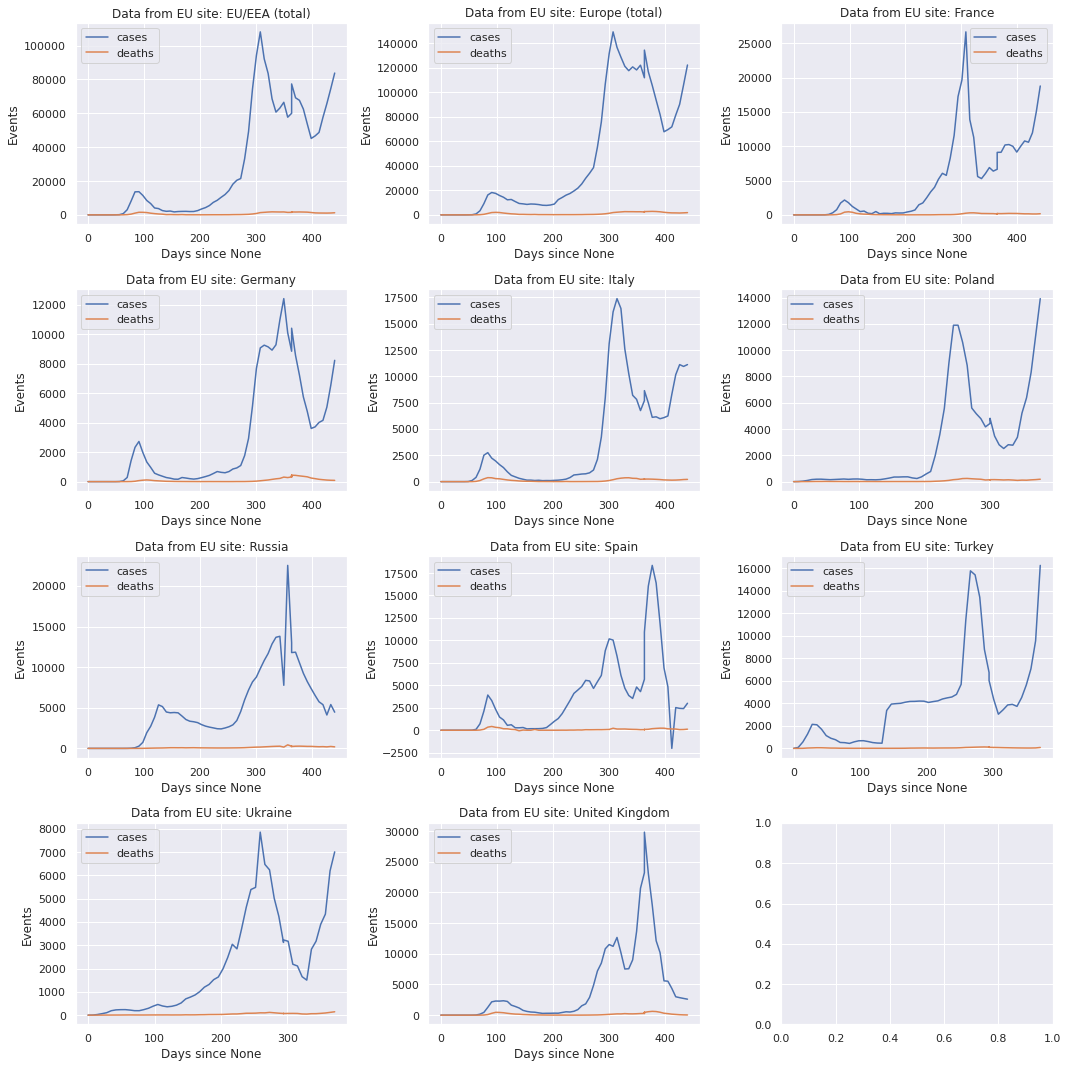

In [20]:
dtg = prepareDataPerCountry(data_covidDataEU, continent="Europe", minPop=2e7)
myEUConverter = EUSiteData()
argDict = { "breakCond" : lambda count, country : count > 12, 
            "countryDataAdapter":myEUConverter}
myFig =  perCountryFigure(**argDict )

plotCols = ( "cases", "deaths")

myFig.initPainter( subnodeSpec=12, maxCol=3)
myFig.mkImage( dtg, plotCols)
ImgMgr.save_fig("FIG001")

Saving figure FIG002


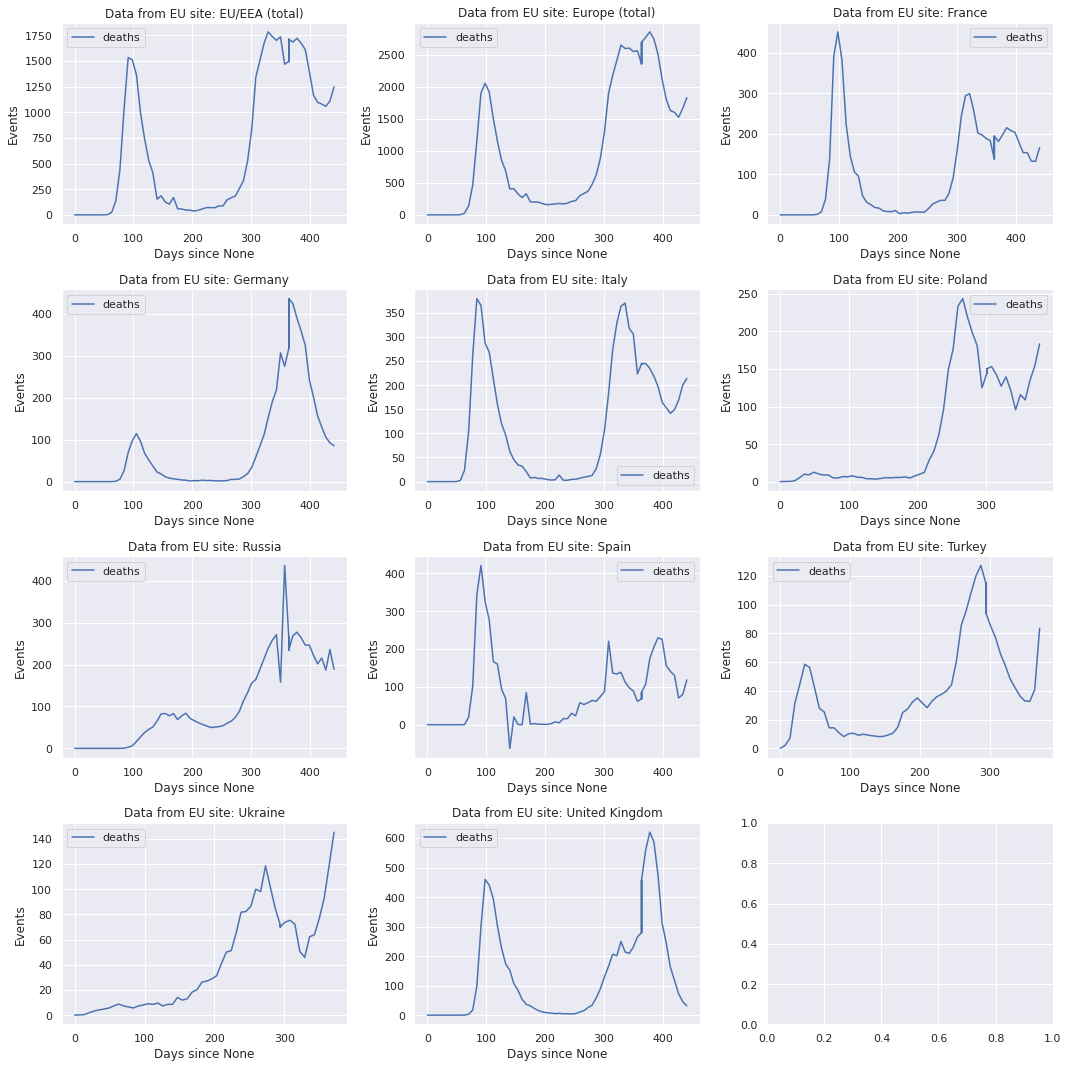

In [21]:
dtg = prepareDataPerCountry(data_covidDataEU, continent="Europe", minPop=2e7)
myEUConverter = EUSiteData()
argDict = { "breakCond" : lambda count, country : count > 12, 
            "countryDataAdapter":myEUConverter}
myFig =  perCountryFigure(**argDict )

plotCols = ( "deaths",)

myFig.initPainter( subnodeSpec=12, maxCol=3)
myFig.mkImage( dtg, plotCols)
ImgMgr.save_fig("FIG002") 

Saving figure FIG003


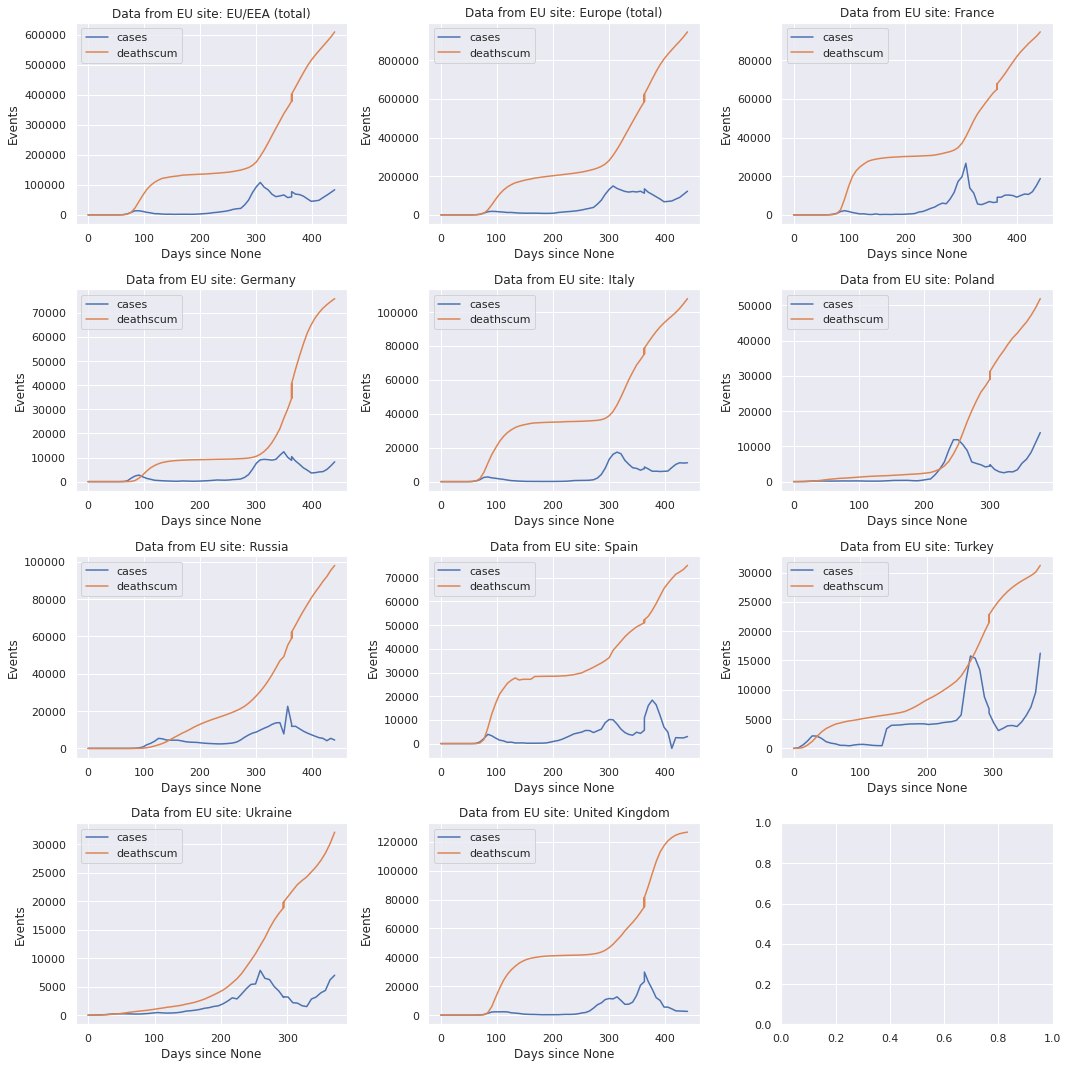

In [22]:
dtg = prepareDataPerCountry(data_covidDataEU, continent="Europe", minPop=2e7)
myEUConverter = EUSiteData()
argDict = { "breakCond" : lambda count, country : count > 12, 
            "countryDataAdapter":myEUConverter}
myFig =  perCountryFigure(**argDict )

plotCols = ( "cases", "deathscum")

myFig.initPainter( subnodeSpec=12, maxCol=3)
myFig.mkImage( dtg, plotCols)
ImgMgr.save_fig("FIG003")

Saving figure FIG004


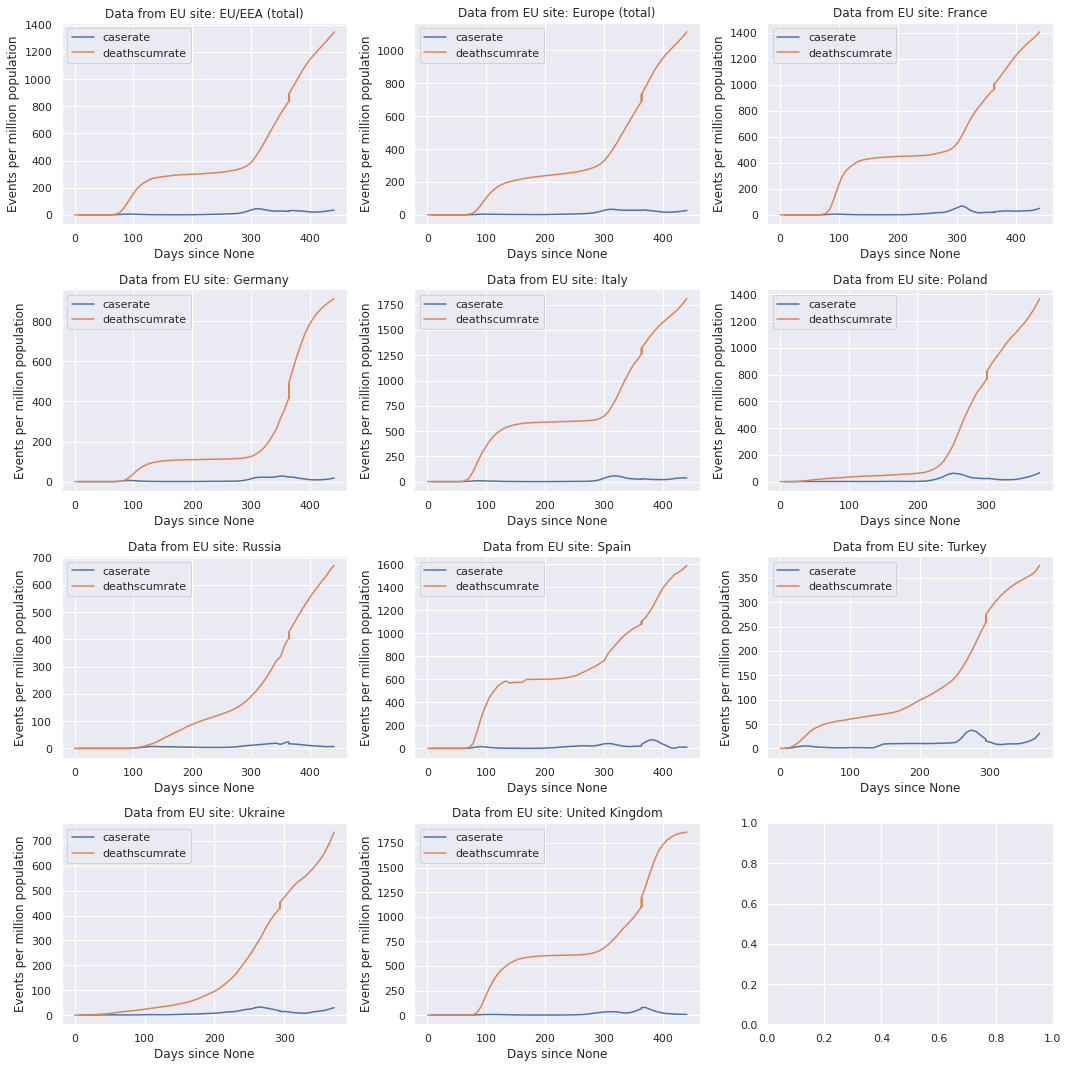

In [23]:
dtg = prepareDataPerCountry(data_covidDataEU, continent="Europe", minPop=2e7)
myEUConverter = EUSiteData()
argDict = { "breakCond" : lambda count, country : count > 12, 
            "countryDataAdapter":myEUConverter}
myFig =  perCountryFigure(**argDict )

plotCols = ( "caserate", "deathscumrate")

myFig.initPainter( subnodeSpec=12, maxCol=3)
myFig.mkImage( dtg, plotCols,  subImgPaintAttrs = perCountryFigure.perMillionSIPA )
ImgMgr.save_fig("FIG004")

Saving figure FIG005


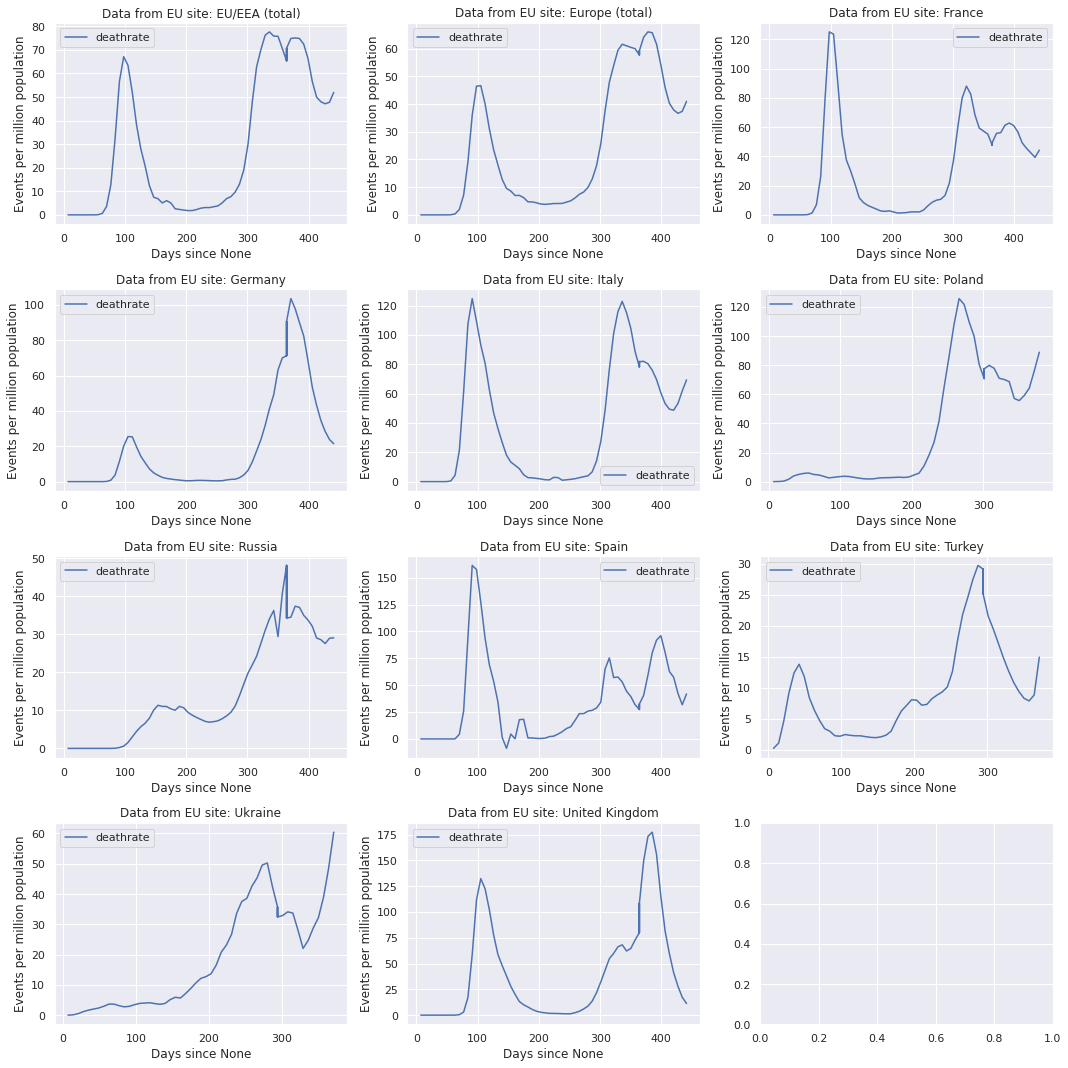

In [24]:
dtg = prepareDataPerCountry(data_covidDataEU, continent="Europe", minPop=2e7)
myEUConverter = EUSiteData()
argDict = { "breakCond" : lambda count, country : count > 12, 
            "countryDataAdapter":myEUConverter}
myFig =  perCountryFigure(**argDict )

plotCols = ( "deathrate",)

myFig.initPainter( subnodeSpec=12, maxCol=3)
myFig.mkImage( dtg, plotCols,  subImgPaintAttrs = perCountryFigure.perMillionSIPA )
ImgMgr.save_fig("FIG005")

### Look at the largest countries

Saving figure FIG021


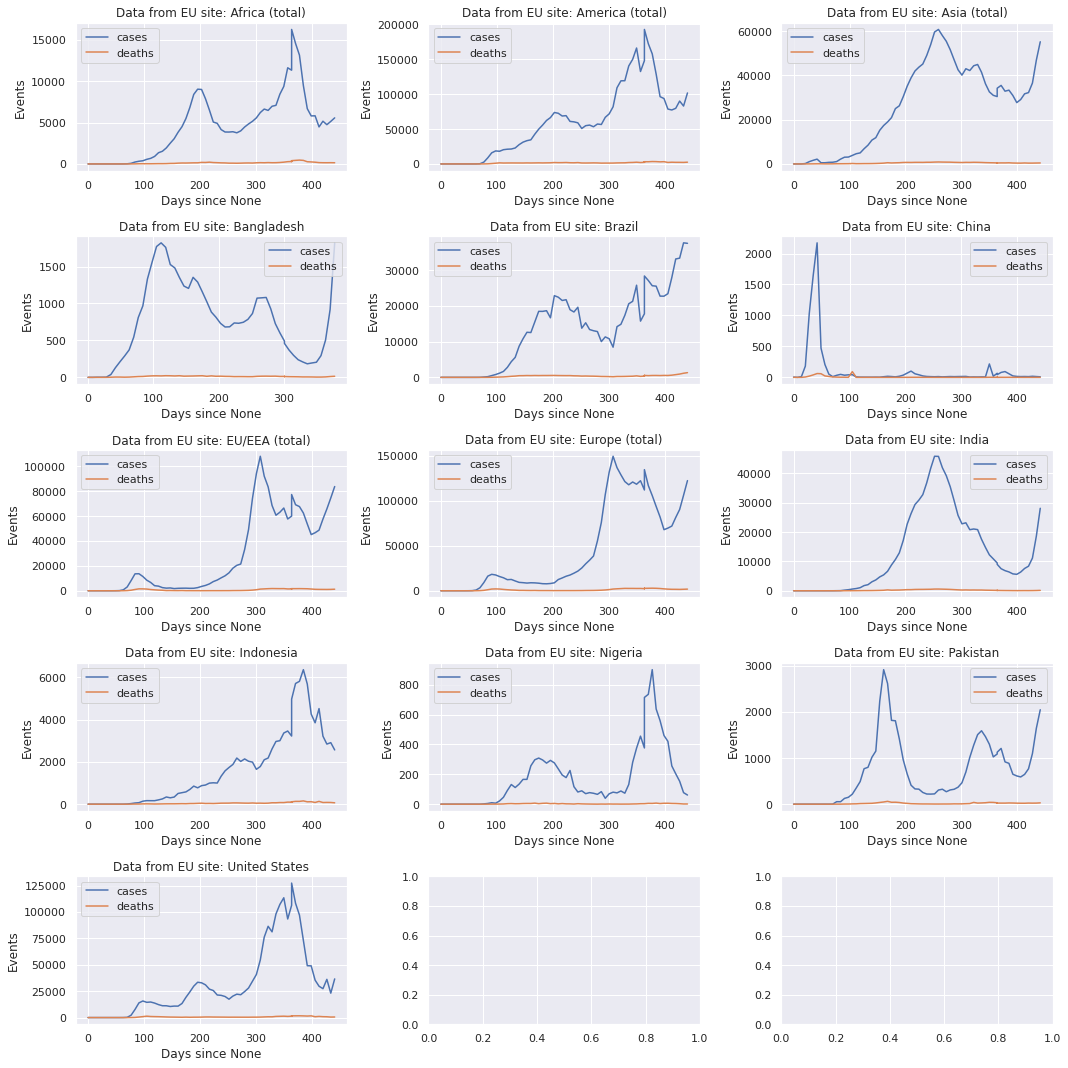

In [25]:
dtg = prepareDataPerCountry(data_covidDataEU, minPop=15e7)
myEUConverter = EUSiteData()
argDict = { "breakCond" : lambda count, country : count > 15, 
            "countryDataAdapter":myEUConverter}
myFig =  perCountryFigure(**argDict )

plotCols = ( "cases", "deaths")

myFig.initPainter( subnodeSpec=15, maxCol=3)
myFig.mkImage( dtg, plotCols)
ImgMgr.save_fig("FIG021")

Saving figure FIG022


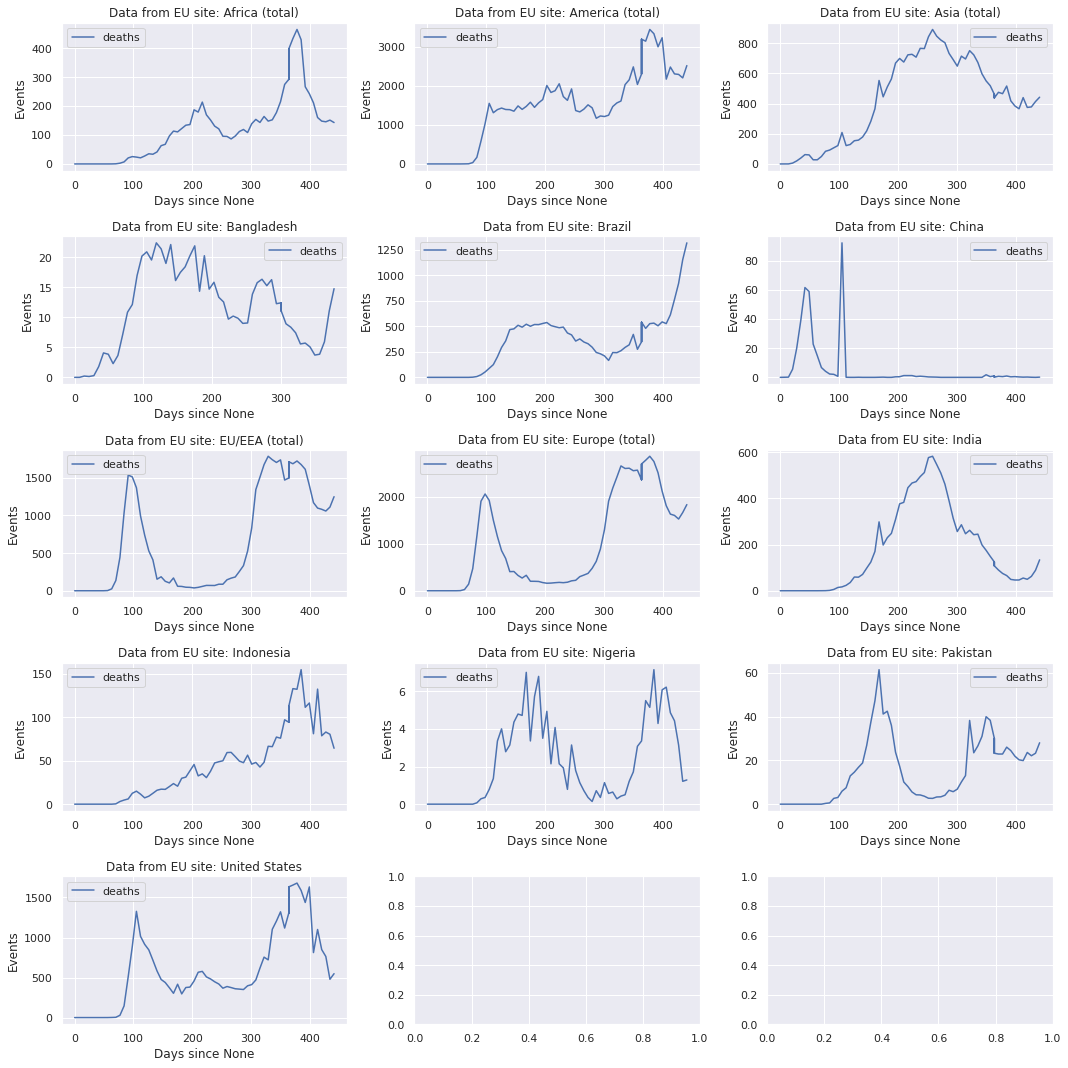

In [26]:
dtg = prepareDataPerCountry(data_covidDataEU, minPop=15e7)
myEUConverter = EUSiteData()
argDict = { "breakCond" : lambda count, country : count > 15, 
            "countryDataAdapter":myEUConverter}
myFig =  perCountryFigure(**argDict )

plotCols = ( "deaths",)

myFig.initPainter( subnodeSpec=15, maxCol=3)
myFig.mkImage( dtg, plotCols)
ImgMgr.save_fig("FIG022") 

Saving figure FIG023


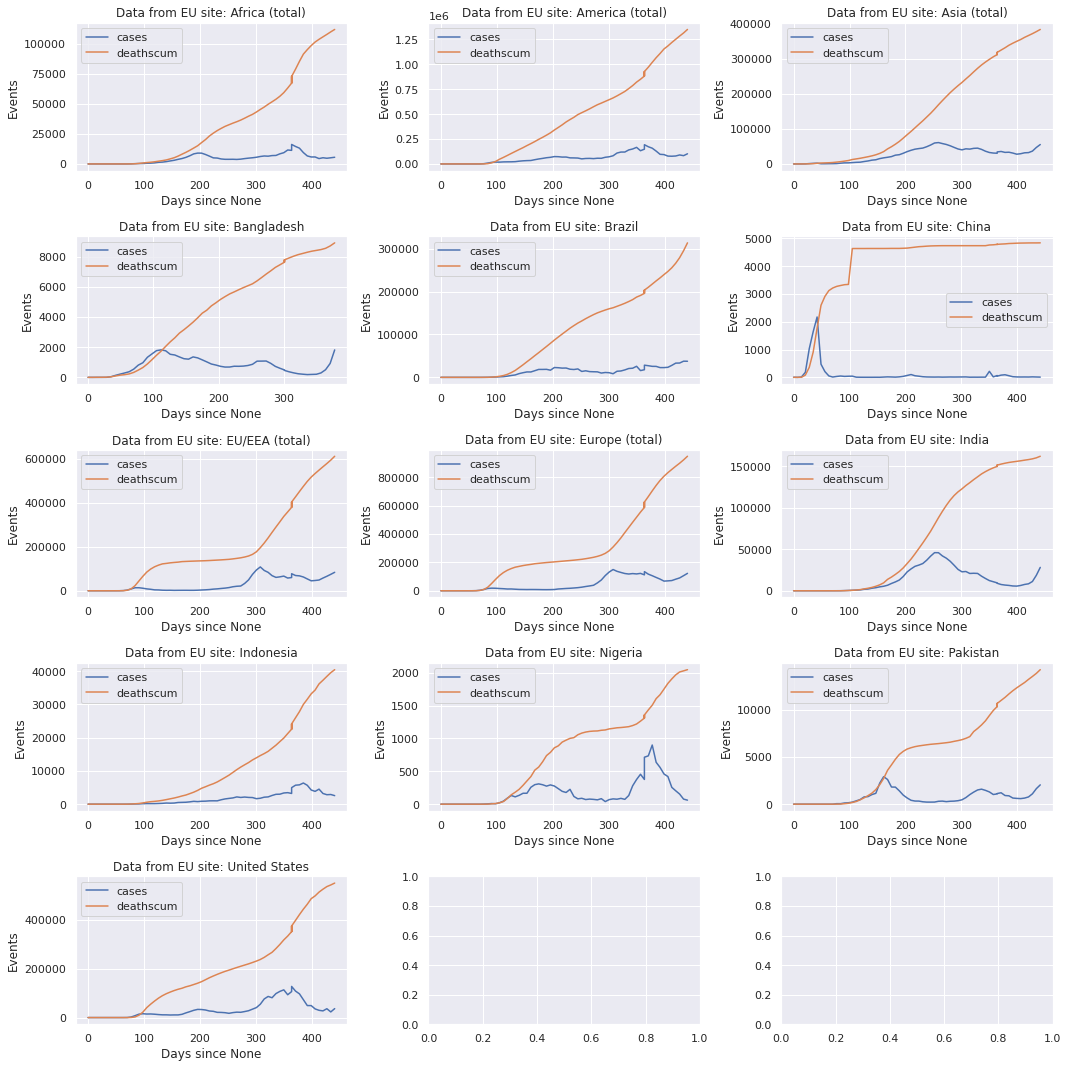

In [27]:
dtg = prepareDataPerCountry(data_covidDataEU, minPop=15e7)
myEUConverter = EUSiteData()
argDict = { "breakCond" : lambda count, country : count > 15, 
            "countryDataAdapter":myEUConverter}
myFig =  perCountryFigure(**argDict )

plotCols = ( "cases", "deathscum")

myFig.initPainter( subnodeSpec=15, maxCol=3)
myFig.mkImage( dtg, plotCols)
ImgMgr.save_fig("FIG023")

Saving figure FIG024


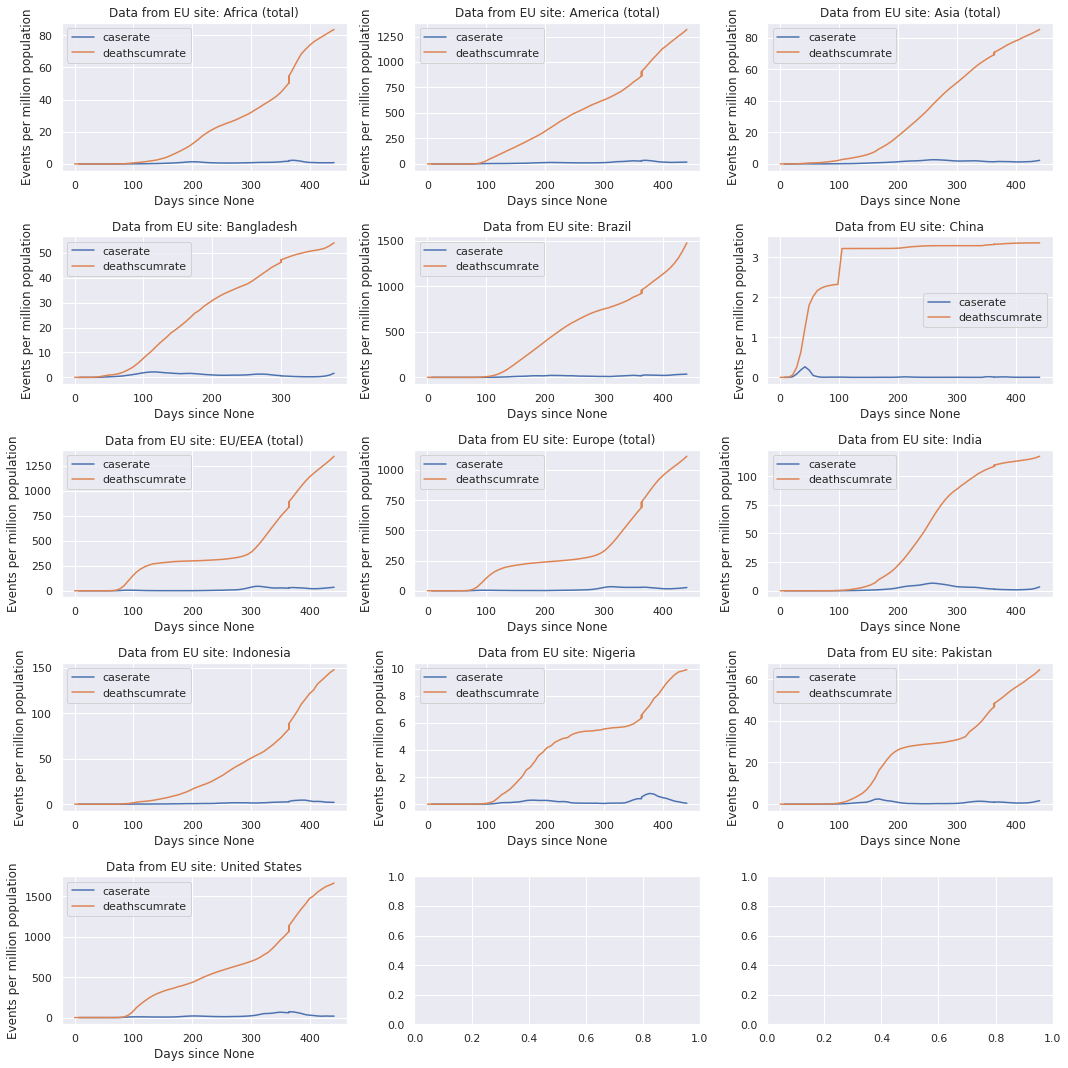

In [28]:
dtg = prepareDataPerCountry(data_covidDataEU, minPop=15e7)
myEUConverter = EUSiteData()
argDict = { "breakCond" : lambda count, country : count > 15, 
            "countryDataAdapter":myEUConverter}
myFig =  perCountryFigure(**argDict )

plotCols = ( "caserate", "deathscumrate")

myFig.initPainter( subnodeSpec=15, maxCol=3)
myFig.mkImage( dtg, plotCols,  subImgPaintAttrs = perCountryFigure.perMillionSIPA )
ImgMgr.save_fig("FIG024")

Saving figure FIG025


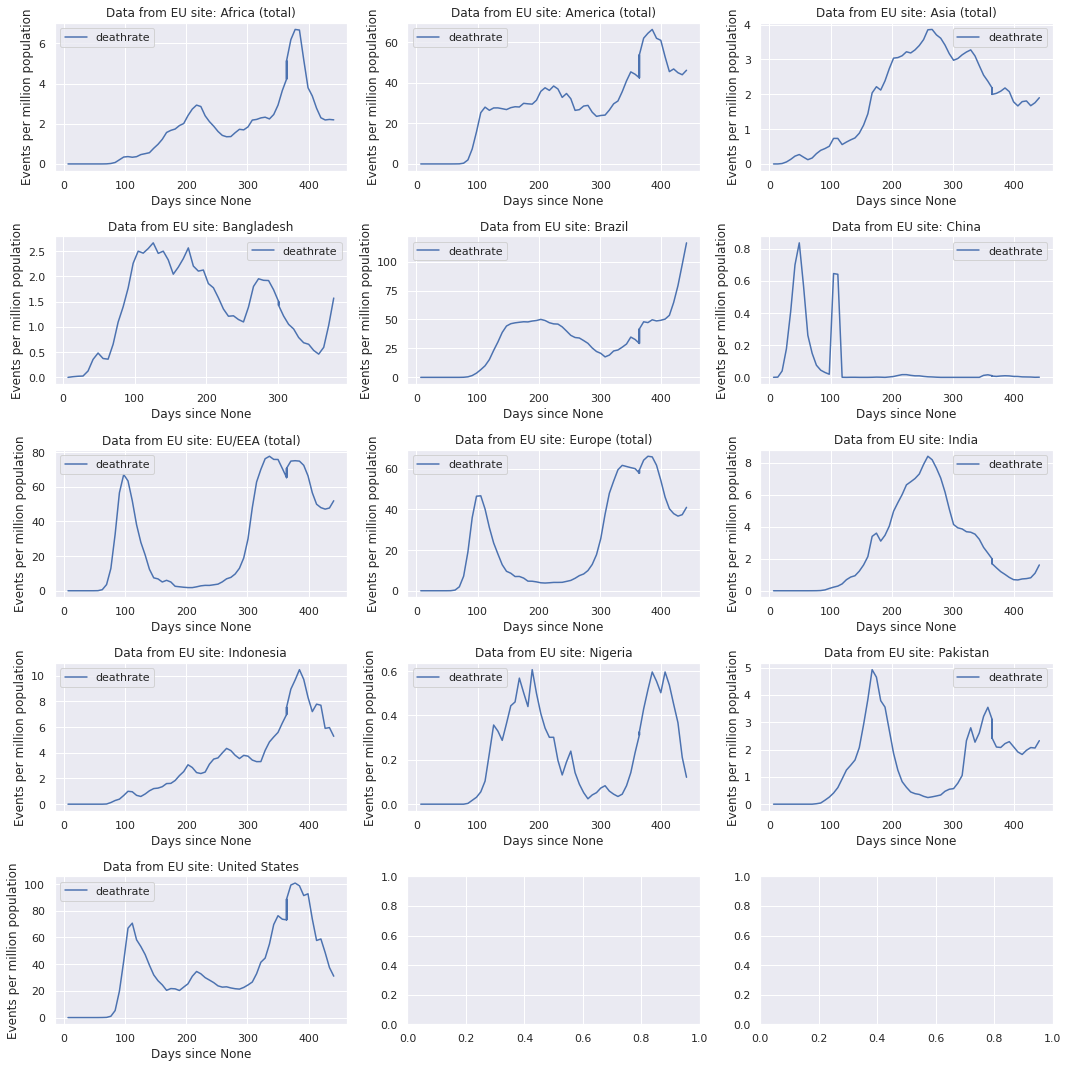

In [29]:
dtg = prepareDataPerCountry(data_covidDataEU,  minPop=15e7)
myEUConverter = EUSiteData()
argDict = { "breakCond" : lambda count, country : count > 15, 
            "countryDataAdapter":myEUConverter}
myFig =  perCountryFigure(**argDict )

plotCols = ( "deathrate",)

myFig.initPainter( subnodeSpec=15, maxCol=3)
myFig.mkImage( dtg, plotCols,  subImgPaintAttrs = perCountryFigure.perMillionSIPA )
ImgMgr.save_fig("FIG025")